<h1> Fire curves </h1>


<h3>Compartment properties</h3>

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import handcalcs.render
import forallpeople as si
import matplotlib.pyplot as plt
from math import tan, sin,cos, pi, radians, sqrt, trunc
from IPython.display import display, Markdown
si.environment('thermal', top_level=True)

In [2]:
def Fire_load(building_type):
    # Fire load densities according to EN 1991-1-2 DK Annex
    if building_type == 'hospital' or building_type == 'cinema' or building_type == 'lecture hall':
        q = 150  # MJ/m^2
    elif building_type == 'office' or building_type == 'residence':
        q = 200  # MJ/m^2
    elif building_type == 'car park':
        q = 300  # MJ/m^2
    else:
        raise ValueError("Please input a valid building type")
    return q*10**6*J_m2

<h4>Fuel load density</h4>

In [3]:
q = Fire_load('lecture hall')

In [4]:
%%render 2
q

<IPython.core.display.Latex object>

<h4>Opening factor<h4>

Enclosure area

In [5]:
%%render param 2
#Area of the "cube" of the compartment

B = 5.5*m
L = 4.5*m
H = 3.5*m


<IPython.core.display.Latex object>

In [6]:
%%render 2

A_t = 2*(B*L + B*H + L*H)

<IPython.core.display.Latex object>

Air flow factor

In [7]:
%%render param 2

h_win = 2.052*m #height of window, i
w_win = 0.8*m #width of window, i

h_door = 0*m#height of door, i
w_door = 0*m#width of door, i


<IPython.core.display.Latex object>

In [26]:
%%render 2

A_win = h_win*w_win #area of window,i
A_door = h_door*w_door #area of door,i
A_o = A_win + A_door #Total opening area
h_av = (h_win*A_win+h_door*A_door)/A_o #Average opening height
AF = (A_o*sqrt(h_av))*m**(1/2) #Air flow factor
O = (AF/A_t).prefix('unity')

<IPython.core.display.Latex object>

<h4>Thermal inertia</h4>

In [9]:
%%render 2

rho = 2300*kg/(m**3)
c = 1000*J/(kg*K)
lamb = 0.8*W/(m*K)
b = (rho*c*lamb)**0.5

<IPython.core.display.Latex object>

* Add thermal inertia calculation of different layers and walls

Parametric curve validity check

In [21]:
if B*L >= 500: 
    display(Markdown('Compartment size not compatible with model.'))
elif H >= 4:
    display(Markdown('Compartment height not compatible with model.'))
elif not(0.019 < O <= 0.2):
    display(Markdown('Opening factor not compatible with model.'))
elif not(100<=b<=2200):
    display(Markdown('Thermal inertia not compatible with model.'))
elif not(50*10**9 < q*(A_t) < 1000*10**9):
    display(Markdown('Fuel load not compatible with model.'))

Fuel load not compatible with model.

In [11]:
t_max = 0.0078*(q.value/10**6)/O.value
t_max = (t_max)*minute

In [12]:
t_max

59.456 minutes

In [14]:
def gamma_f(O,b):
    return (O.value/0.04/(b.value/1160))**2

In [15]:
gamma = gamma_f(O,b)

In [16]:
deltat = t_max/12

In [17]:
deltat

4.955 minutes

In [18]:
t_max

59.456 minutes

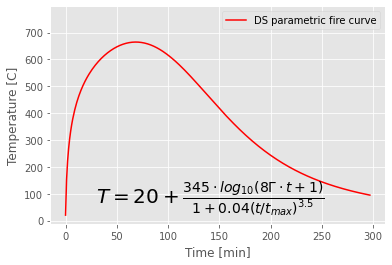

In [19]:
t_max = 0.0078*(q.value/10**6)/O.value
t = np.arange(0,t_max*5)
T = 20+345*np.log10(8*gamma_f(O,b)*t+1)/(1+0.04*(t/t_max)**3.5)
T_max = T.max()
plt.style.use('ggplot')
plt.plot(t,T, label="DS parametric fire curve", color = 'red')
plt.ylim(ymax=max(T)*1.2)
plt.legend()
plt.xlabel("Time [min]")
plt.ylabel("Temperature [C]")
plt.text(0.5 * (0 + t_max), 0.1 * (0 + T_max),
     r"$T=20 + \frac{345\cdot log_{10}(8\Gamma \cdot t+1)}{1+0.04(t/t_{max})^{3.5}}$", horizontalalignment='left',
     fontsize=20)
plt.show()